# Homework 3 

You will have 2 datasets to work on. 
#### You have to answer questions in this [form](https://goo.gl/forms/5gfxvKZxpoydoeOB2) and provide your code

### 1. Wikipedia Web Traffic Time Series

Data from [Kaggle competition](https://www.kaggle.com/c/web-traffic-time-series-forecasting)* )

*wikipedia_train3* - train data *wikipedia_test3* - test data created by us from original train data . For more information about dataset, please visit Homework1 assignment


### 2. French dataset

Target variable is prime_tot_ttc – house of insurance price.<p>
The variables in the files are:<p>
code_postal: postal code of the insured property<p>
nb_pieces: number of rooms<p>
veranda: presence of a veranda<p>
biens_nomades: ceiling of coverage of goods (laptop, tablets, musical instruments ,…)<p>
sit_fam: family situation of the insured<p>
profession: profession of the insured<p>
nature_lri: nature of the insured property<p>
societe: company covering the risk<p>
cdomact: area of activity of the insured<p>
niv_urbanisation: level of urbanization in which is the insured property<p>
age_societaire: age of the member<p>
objets_precieux: presence of precious objects in the insured property<p>
pres_contrat_auto: holding a contract of auto insurance<p>
formule: guarantee formula<p>
sit_juridique: legal situation<p>
surf_habitat: area of insured property<p>
patrimoine_mob: amount of heritage insured furniture<p>
var1 - ... - var11: non-explicit variables<p>


In [3]:
import pandas as pd
import numpy as np
#for EDA
import pandas_profiling as pp


from dateutil.relativedelta import relativedelta
import math
from math import fabs

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder

# vizualizing
import matplotlib.pyplot as plt
% matplotlib inline 
import seaborn as sns
import matplotlib.style as style
import calmap 
import warnings
warnings.simplefilter('ignore')

## Wikipedia page views (SMAPE metric)

In [4]:
train = pd.read_csv("../data/wikipedia3/wikipedia_train3.csv", parse_dates=['date'])
test = pd.read_csv("../data/wikipedia3/wikipedia_test3.csv", parse_dates=['date'])

**1.** Take a look carefuly at train and test dataset. Note for you what is the difference in them and how they are dependent. **For _only_ train** create a holdout validation using any type of split you think is useful here. What is the split type you are using? Answer in google forms

**2.** Write a code to compare the score of your validation and test set. For scoring, use metric SMAPE (code is in lecture). For prediction use 15 previous days median. In the google form write your validation score.

In [5]:
train.sample(5)

,Page,date,Visits
612644,Neymar_es.wikipedia.org_mobile-web_all-agents,2016-02-21,2241.0
2279769,橋下徹_ja.wikipedia.org_all-access_all-agents,2016-07-11,6025.0
336277,Amanda_Nunes_en.wikipedia.org_all-access_all-a...,2016-01-29,680.0
2828473,Mount_Everest_en.wikipedia.org_all-access_all-...,2016-08-27,9296.0
1655745,Celine_Dion_en.wikipedia.org_desktop_all-agents,2016-05-20,4583.0


In [6]:
test.sample(5)

,Page,date,Visits
374308,John_Legend_en.wikipedia.org_mobile-web_all-ag...,2016-10-11,3535.0
690895,Supreme_Court_of_the_United_States_en.wikipedi...,2016-11-07,10808.0
460720,YouTube_de.wikipedia.org_all-access_all-agents,2016-10-18,2027.0
677332,Taylor_Momsen_en.wikipedia.org_all-access_all-...,2016-11-06,5254.0
644693,Black_Panther_(comics)_en.wikipedia.org_mobile...,2016-11-03,2061.0


Text(0.73,0.8,'Test')

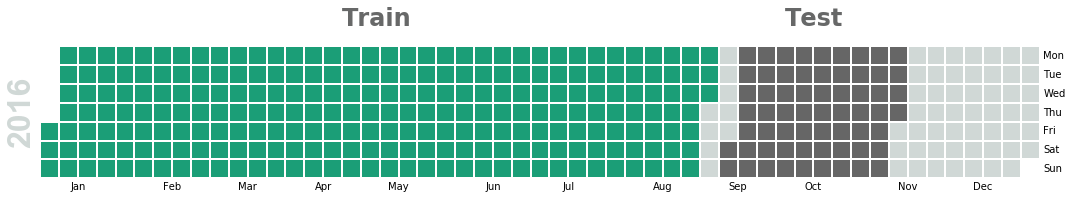

In [7]:
#vizualizing time period 
train_data = train.date.value_counts() * 0
test_data = test.date.value_counts()
all_data = pd.concat([train_data, test_data])

fig, ax = calmap.calendarplot(all_data, fig_kws={"figsize":(15,4)}, fillcolor='#d0d8d6', cmap='Dark2')
fig.text(x=0.32, y=0.8, s="Train", fontsize=24, weight='bold', color='#676868')
fig.text(x=0.73, y=0.8, s="Test", fontsize=24, weight='bold', color='#676868')

Test dataset consists of visits data by the next two month, which were unseen in the train dataset. Size of the test dataset is two month. Test dataset is balanced. So to create a holdout dataset we  should use last two month or time period simular to test in the train dataset 

In [8]:
def train_test_split(df, start, finish):
    train= df.loc[df.date < start]
    test = df.loc[(df.date >= start)&\
                  (df.date <= finish)]
    return train, test

def smape_fast(y_true, y_pred):
    out = 0
    for i in range(y_true.shape[0]):
        a = y_true.iloc[i]
        b = y_pred[i]
        if b < 1:
            b = 0
        c = a+b
        if c == 0:
            continue
        out += math.fabs(a - b) / c
    out *= (200.0 / y_true.shape[0])
    return out

def get_median_smape(train, test, n_days=15):
    last_days_median = train[train['date'] > np.max(train['date']) - pd.Timedelta(days=n_days)].groupby('Page')['Visits'].median().reset_index()
    last_days_median.rename(columns={"Visits": "pred_Visits"}, inplace=True)
    y_pred_days = test.merge(last_days_median, on='Page', how='left').pred_Visits
    return smape_fast(test.Visits, y_pred_days)

In [ ]:
#to saving structure of test dataset(number of weekends, which are very important(hw1)) - getting holdout by weeks 
#(by day of months give worse results (from 10 ..))
start = test.date.min() - relativedelta( days=10 * 7)
finish = test.date.max() - relativedelta(days=10 * 7+1)
tmp_train, holdout = train_test_split(train, start, finish)

#vizualizing periods 
total_data = pd.concat([tmp_train.date.value_counts() * 0 , holdout.date.value_counts() * 0.8 , test.date.value_counts()])
fig, ax = calmap.calendarplot(total_data, fig_kws={"figsize":(15,4)}, fillcolor='#d0d8d6', cmap='Dark2')
fig.text(x=0.54, y=0.8, s="Holdout", fontsize=24, weight='bold', color='#676868')
fig.text(x=0.73, y=0.8, s="Test", fontsize=24, weight='bold', color='#676868')


#comparrisson of smape error on test and holdout dataset 
smape_train_test = get_median_smape(train, test, 15)
smape_trains_houldout = get_median_smape(tmp_train, holdout, 15)
diff = fabs(smape_train_test - smape_trains_houldout)
print(f"SMAPE test {smape_train_test}\nSMAPE holdout {smape_trains_houldout} \nDiff {diff}")


SMAPE test 40.00701270204617
SMAPE holdout 39.52306683023146 
Diff 0.4839458718147114


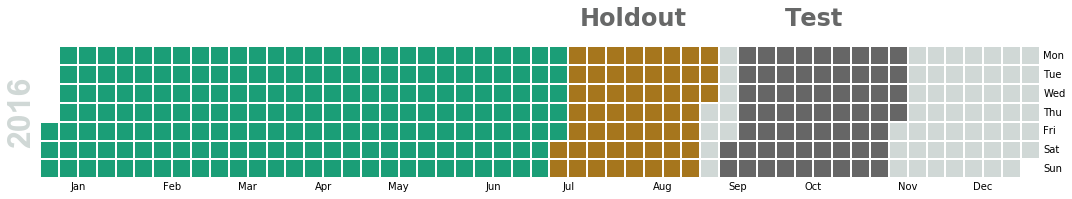

In [10]:
#to saving structure of test dataset(number of weekends, which are very important(hw1)) - getting holdout by weeks 
#(by day of months give worse results (from 10 ..))
start = test.date.min() - relativedelta( days=9 * 7)
finish = test.date.max() - relativedelta(days=10 * 7+1)
tmp_train, holdout = train_test_split(train, start, finish)

#vizualizing periods 
total_data = pd.concat([tmp_train.date.value_counts() * 0 , holdout.date.value_counts() * 0.8 , test.date.value_counts()])
fig, ax = calmap.calendarplot(total_data, fig_kws={"figsize":(15,4)}, fillcolor='#d0d8d6', cmap='Dark2')
fig.text(x=0.54, y=0.8, s="Holdout", fontsize=24, weight='bold', color='#676868')
fig.text(x=0.73, y=0.8, s="Test", fontsize=24, weight='bold', color='#676868')


#comparrisson of smape error on test and holdout dataset 
smape_train_test = get_median_smape(train, test, 15)
smape_trains_houldout = get_median_smape(tmp_train, holdout, 15)
diff = fabs(smape_train_test - smape_trains_houldout)
print(f"SMAPE test {smape_train_test}\nSMAPE holdout {smape_trains_houldout} \nDiff {diff}")


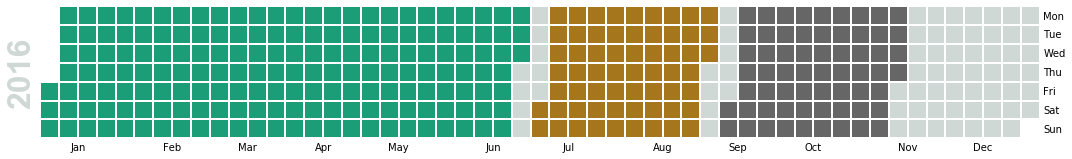

In [11]:
def get_valid_folf(df, start, finish):
    test = df.loc[(df.date >= start)&(df.date <= finish)]
    return  test.index


#when try to save a gap between test and train 
start_v = test.date.min() - relativedelta(days=(10) * 7)
finish_v = test.date.max() - relativedelta(days=(10 ) * 7 + 1)
validation_indecis = get_valid_folf(train, start_v, finish_v)
    
#getting training fold
start_tr = test.date.min() - relativedelta(days=(36 ) * 7 + 1)
finish_tr = test.date.max() - relativedelta(days=(20 ) * 7 + 1)
tmp_train_indices = get_valid_folf(train, start_tr, finish_tr)

total_data = pd.concat([train.iloc[tmp_train_indices].date.value_counts() * 0 , 
                        train.iloc[validation_indecis].date.value_counts() * 0.8 , 
                        test.date.value_counts()])
    
fig, ax = calmap.calendarplot(total_data, fig_kws={"figsize":(15,4)}, fillcolor='#d0d8d6', cmap='Dark2')

In [12]:
#comparrisson of smape error on test and holdout dataset 
smape_train_test = get_median_smape(train, test, 15)
smape_trains_houldout = get_median_smape(train.iloc[tmp_train_indices], train.iloc[validation_indecis], 15)
diff = fabs(smape_train_test - smape_trains_houldout)
print(f"SMAPE test {smape_train_test}\nSMAPE holdout {smape_trains_houldout} \nDiff {diff}")
#ne horosha sproba

SMAPE test 40.00701270204617
SMAPE holdout 44.737722097768504 
Diff 4.730709395722336


In [21]:
%%time
n_weeks = np.arange(5, 11)
C_medians = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 60, 75] 

df = pd.DataFrame(index=n_weeks, columns=['Diff_if_m' + str(c) for c in C_medians] + ['sum', 'mean'])#dataframe for results

def train_test_split(df, start):
    train= df.loc[df.date < start]
    test = df.loc[(df.date >= start)]
    return train, test

for n_w in range(1, 13):
    start = test.date.min() - relativedelta(days=(n_w + 1) * 7)
    tr, tst = train_test_split(train, start)
    diffs = []
    for m in C_medians:
        smape_train_test = get_median_smape(train, test, m)
        smape_trains_houldout = get_median_smape(tr, tst, m)
        diff = fabs(smape_train_test - smape_trains_houldout)
        diffs.append(diff)
    df.loc[n_w] = diffs + [np.sum(diffs), np.mean(diffs)]#appending a record to df    

CPU times: user 58min 17s, sys: 23.6 s, total: 58min 40s
Wall time: 59min 12s


In [22]:
df 

,Diff_if_m1,Diff_if_m2,Diff_if_m3,Diff_if_m4,Diff_if_m5,Diff_if_m10,Diff_if_m15,Diff_if_m20,Diff_if_m25,Diff_if_m30,Diff_if_m60,Diff_if_m75,sum,mean
5,6.473617,7.195789,7.266902,7.547180,7.361199,6.270145,6.500043,6.814556,6.604935,6.056776,2.738556,2.013876,72.843574,6.070298
6,4.760839,5.648542,5.963389,6.420192,6.339924,5.247330,5.018830,4.583994,4.061766,3.621188,1.217163,0.303863,53.187021,4.432252
7,4.181350,4.482958,4.316471,4.568554,4.388633,2.279987,2.178301,2.137970,1.922712,1.724652,0.337390,1.309087,33.828064,2.819005
8,1.315469,1.513052,1.660286,1.999158,1.900123,0.546051,0.483946,0.780714,0.472182,0.206344,1.642125,2.601204,15.120654,1.260054
9,0.021984,0.594443,0.446070,0.441068,0.113256,1.054451,0.725421,0.814373,0.811432,0.732582,2.836184,3.597006,12.188270,1.015689
10,1.943856,1.562457,1.487073,1.301628,1.283911,2.322818,2.251546,1.903496,1.860864,1.770617,3.984015,4.538398,26.210678,2.184223
1,15.522951,15.950129,15.385420,15.681525,15.389581,12.102293,11.362913,11.054896,10.934012,10.831189,10.165799,9.130901,153.511609,12.792634
2,11.275087,12.224322,12.026653,12.543231,12.578152,10.683618,10.701645,11.353361,11.133933,10.691796,8.979857,7.376453,131.568108,10.964009
3,10.189548,11.323488,11.499939,11.787668,11.603066,10.406013,10.240687,9.970965,9.269973,9.081841,6.257905,5.178802,116.809896,9.734158
4,8.786395,9.463694,9.807018,10.146943,9.926594,7.706004,7.322420,7.583731,7.474991,7.230391,4.029628,3.222156,92.699966,7.724997


In [13]:
%%time
n_weeks = np.arange(5, 11)
C_medians = range(11, 30, 2) 

df = pd.DataFrame(index=n_weeks, columns=['Diff_if_m' + str(c) for c in C_medians] + ['sum', 'mean'])#dataframe for results

def train_test_split(df, start):
    train= df.loc[df.date < start]
    test = df.loc[(df.date >= start)]
    return train, test

for n_w in range(1, 13):
    start = test.date.min() - relativedelta(days=(n_w + 1) * 7)
    tr, tst = train_test_split(train, start)
    diffs = []
    for m in C_medians:
        smape_train_test = get_median_smape(train, test, m)
        smape_trains_houldout = get_median_smape(tr, tst, m)
        diff = fabs(smape_train_test - smape_trains_houldout)
        diffs.append(diff)
    df.loc[n_w] = diffs + [np.sum(diffs), np.mean(diffs)]#appending a record to df    

CPU times: user 51min 36s, sys: 29 s, total: 52min 5s
Wall time: 53min 26s


In [14]:
df

,Diff_if_m11,Diff_if_m13,Diff_if_m15,Diff_if_m17,Diff_if_m19,Diff_if_m21,Diff_if_m23,Diff_if_m25,Diff_if_m27,Diff_if_m29,sum,mean
5,6.379920,6.491180,6.500043,6.720510,6.840609,6.730217,6.584259,6.604935,6.538315,6.234638,65.624627,6.562463
6,5.277249,5.231098,5.018830,4.883314,4.821187,4.344222,4.096711,4.061766,3.924705,3.711319,45.370401,4.537040
7,2.434502,2.295619,2.178301,2.273773,2.276391,2.033444,1.946380,1.922712,1.933528,1.807518,21.102168,2.110217
8,0.545699,0.417094,0.483946,0.600512,0.752162,0.786002,0.599188,0.472182,0.366614,0.224731,5.248130,0.524813
9,0.996238,0.824056,0.725421,0.704799,0.801310,0.767257,0.850250,0.811432,0.701464,0.690193,7.872419,0.787242
10,2.515634,2.491228,2.251546,2.100752,2.024580,1.731158,1.821280,1.860864,1.710232,1.645367,20.152641,2.015264
1,11.743201,11.704799,11.362913,11.112610,11.101530,10.950171,10.789825,10.934012,11.066320,10.899814,111.665195,11.166519
2,10.761590,10.802617,10.701645,10.930448,11.296613,11.314639,11.157610,11.133933,11.072949,10.760248,109.932292,10.993229
3,10.502162,10.596612,10.240687,10.117927,10.109587,9.821210,9.462309,9.269973,9.251469,9.088604,98.460540,9.846054
4,7.595773,7.453988,7.322420,7.476474,7.654900,7.553532,7.488104,7.474991,7.482677,7.283638,74.786496,7.478650


In [ ]:
# best holdout size ~ 8 - 9 month 

In [220]:
def train_test_split(df, n_months=2):
    train= df.loc[df.date < df.date.max() - relativedelta(months=1+n_months) + relativedelta(days = 10)]
    test = df.loc[(df.date >= df.date.max() - relativedelta(months=1+n_months) + relativedelta(days = 10))&\
                  (df.date <= df.date.max() - relativedelta(months=1) + relativedelta(days = 10))]
    return train, test

def train_test_split_(df):
    train= df.loc[df.date <= df.date.max() - relativedelta(months=2)]
    test = df.loc[df.date > df.date.max() - relativedelta(months=2)]
    return train, test


In [212]:
tr, tst = train_test_split(train)

In [18]:
def smape_fast(y_true, y_pred):
    out = 0
    for i in range(y_true.shape[0]):
        a = y_true.iloc[i]
        b = y_pred[i]
        if b < 1:
            b = 0
        c = a+b
        if c == 0:
            continue
        out += math.fabs(a - b) / c
    out *= (200.0 / y_true.shape[0])
    return out

def get_median_smape(train, test, n_days=15):
    last_days_median = train[train['date'] > np.max(train['date']) - pd.Timedelta(days=n_days)].groupby('Page')['Visits'].median().reset_index()
    last_days_median.rename(columns={"Visits": "pred_Visits"}, inplace=True)
    y_pred_days = test.merge(last_days_median, on='Page', how='left').pred_Visits
    return smape_fast(test.Visits, y_pred_days)

def train_test_split(df, test_size):
    train= df.loc[df.date <= df.date.max() - test_size]
    test = df.loc[df.date > df.date.max() - test_size]
    return train, test

def get_score(train, test, holdout_size, n_median=15):
    train_s, holdout_s = train_test_split(train, holdout_size)
    smape_train_test = get_median_smape(train, test, n_median)
    smape_trains_houldout = get_median_smape(train_s, holdout_s, n_median)
    diff = fabs(smape_train_test - smape_trains_houldout)
  # print(f"SMAPE test {smape_train_test}\nSMAPE holdout {smape_trains_houldout} \nDiff {diff}")
    return smape_train_test, smape_trains_houldout, diff


**3.** Perform K-fold validation using your type of split. Run GridSearch with any classificator you like and set of parameters to optimize, providing it with your custom validation.  Compare the score of your validation and test set. For scoring, again, use metrics SMAPE. In the google form write your scores on validation and test sets

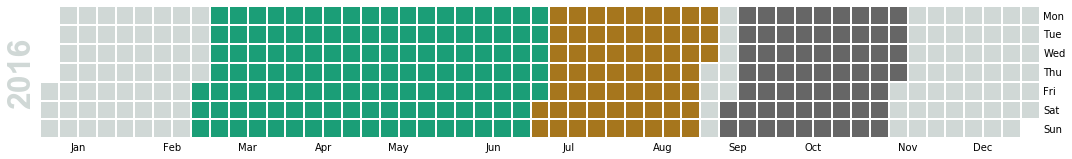

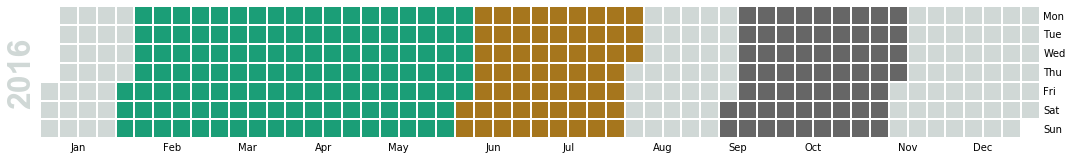

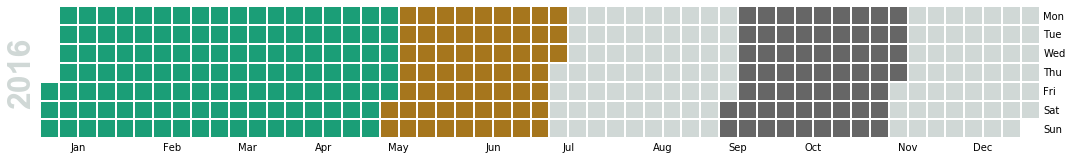

In [21]:
Time3KF = [] # custon CVIterator
m = 4  #4 weeks = size of shifting 

def get_valid_folf(df, start, finish):
    test = df.loc[(df.date >= start)&(df.date <= finish)]
    return  test.index

for k in range(3):
    #getting validation fold
    start_v = test.date.min() - relativedelta(days=(10 + m * k) * 7)
    finish_v = test.date.max() - relativedelta(days=(10 + m * k) * 7 + 1)
    validation_indecis = get_valid_folf(train, start_v, finish_v)
    
    #getting training fold
    start_tr = test.date.min() - relativedelta(days=(28 + m * k) * 7 + 1)
    finish_tr = test.date.max() - relativedelta(days=(18 + m * k) * 7 - 1)
    tmp_train_indices = get_valid_folf(train, start_tr, finish_tr)
    
    #adding train_validation to custom CVIterator 
    Time3KF.append((tmp_train_indices, validation_indecis ))

    #vizualizing data which we use in validation
    total_data = pd.concat([train.iloc[tmp_train_indices].date.value_counts() * 0 , 
                            train.iloc[validation_indecis].date.value_counts() * 0.8 , 
                            test.date.value_counts()])
    
    fig, ax = calmap.calendarplot(total_data, fig_kws={"figsize":(15,4)}, fillcolor='#d0d8d6', cmap='Dark2')

train: 2016-01-01 - 2016-02-29    validation:  2016-03-01 - 2016-04-30
train: 2016-02-01 - 2016-03-31    validation:  2016-04-01 - 2016-05-31
train: 2016-03-01 - 2016-04-30    validation:  2016-05-01 - 2016-06-30
train: 2016-04-01 - 2016-05-31    validation:  2016-06-01 - 2016-07-31
train: 2016-05-01 - 2016-06-30    validation:  2016-07-01 - 2016-08-31


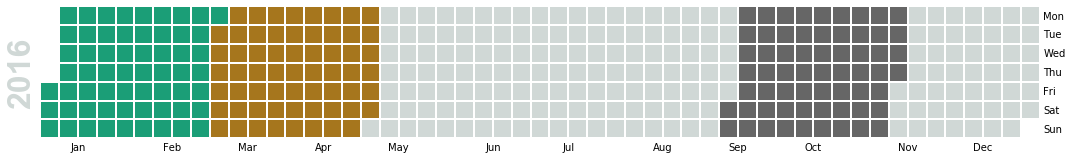

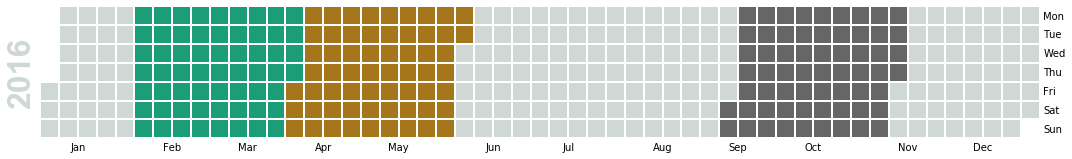

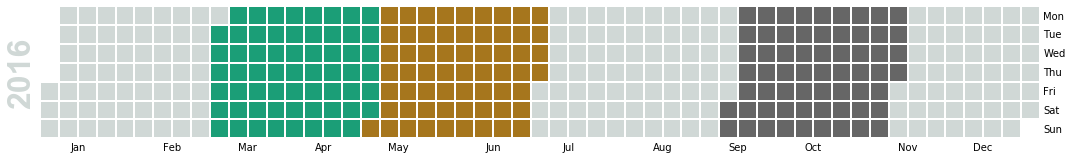

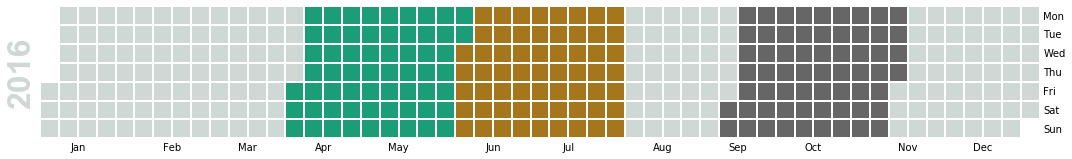

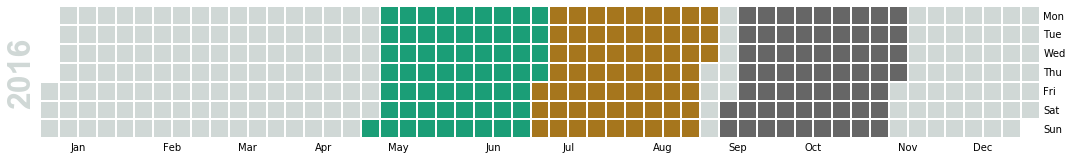

In [30]:
#not correct ideological(size of train is changing,)
#but gives the most stable and the closest results to test dataset (?????)

#my KFold Validation k = 4 , 2month
def create_KFvalidation(df, default_month):
    return df.loc[(df["date"] < pd.to_datetime(default_month))&(df['date']> pd.to_datetime(default_month)-relativedelta(months=2, days=1))].index,\
           df.loc[(df["date"] >= pd.to_datetime(default_month)) &\
                  (df["date"] < pd.to_datetime(default_month)+ relativedelta(months=2))].index #validation inices
    
train_dates = ['2016-03-01', '2016-04-01','2016-05-01','2016-06-01', '2016-07-01']
KFold = [create_KFvalidation(train, i) for i in train_dates]



#just for understanding what data do we use in validation 
for train_validation in KFold:
    print( "train: {} - {}    validation:  {} - {}"\
         .format(train.loc[train_validation[0], 'date'].min().strftime('%Y-%m-%d %H:%M:%S')[:10],
                 train.loc[train_validation[0], 'date'].max().strftime('%Y-%m-%d %H:%M:%S')[:10],
                 train.loc[train_validation[1], 'date'].min().strftime('%Y-%m-%d %H:%M:%S')[:10],
                 train.loc[train_validation[1], 'date'].max().strftime('%Y-%m-%d %H:%M:%S')[:10]))
    
#vizualising what data do we use in validation     
for train_validation in KFold:
    total_data = pd.concat([train.iloc[train_validation[0]].date.value_counts() * 0 , 
                            train.iloc[train_validation[1]].date.value_counts() * 0.8 , 
                            test.date.value_counts()])

    fig, ax = calmap.calendarplot(total_data, fig_kws={"figsize":(15,4)}, fillcolor='#d0d8d6', cmap='Dark2')
    

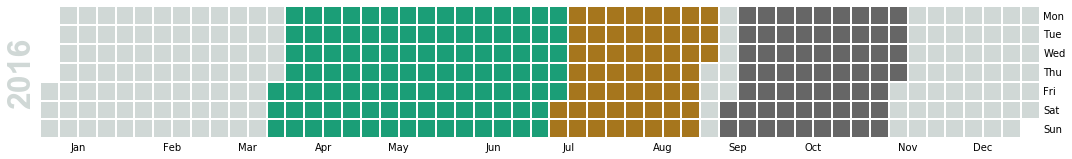

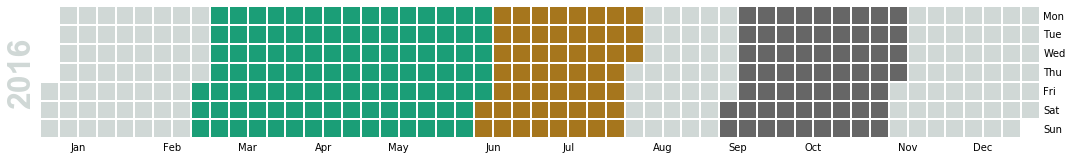

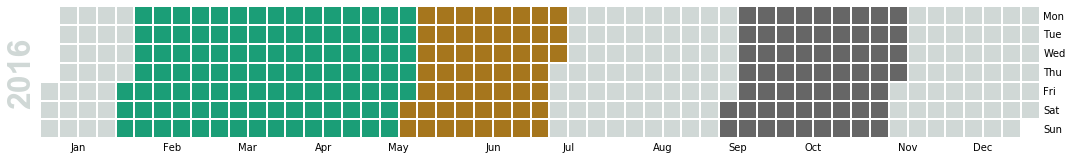

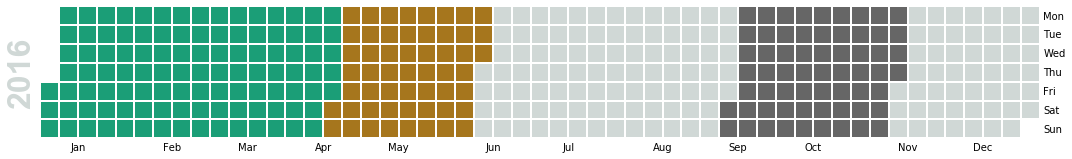

In [22]:
Time4KF = [] # custon CVIterator
m = 4  #4 weeks = size of shifting 

def get_valid_folf(df, start, finish):
    test = df.loc[(df.date >= start)&(df.date <= finish)]
    return  test.index

for k in range(4):
    #getting validation fold
    start_v = test.date.min() - relativedelta(days=(9 + m * k) * 7)
    finish_v = test.date.max() - relativedelta(days=(10 + m * k) * 7 + 1)
    validation_indecis = get_valid_folf(train, start_v, finish_v)
    
    #getting training fold
    start_tr = test.date.min() - relativedelta(days=(24 + m * k) * 7 + 1)
    finish_tr = test.date.max() - relativedelta(days=(18 + m * k) * 7 - 1)
    tmp_train_indices = get_valid_folf(train, start_tr, finish_tr)
    
    #adding train_validation to custom CVIterator 
    Time4KF.append((tmp_train_indices, validation_indecis ))

    #vizualizing data which we use in validation
    total_data = pd.concat([train.iloc[tmp_train_indices].date.value_counts() * 0 , 
                            train.iloc[validation_indecis].date.value_counts() * 0.8 , 
                            test.date.value_counts()])
    
    fig, ax = calmap.calendarplot(total_data, fig_kws={"figsize":(15,4)}, fillcolor='#d0d8d6', cmap='Dark2')

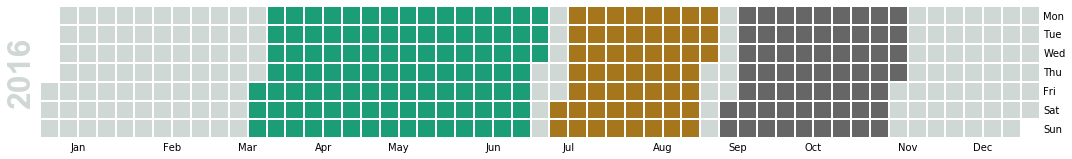

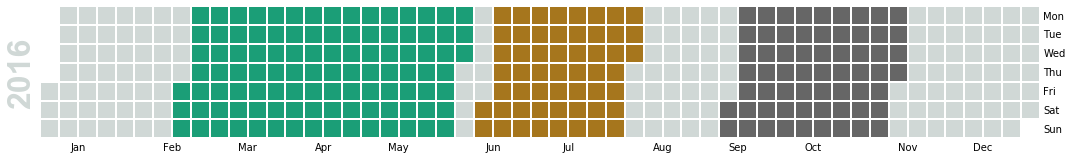

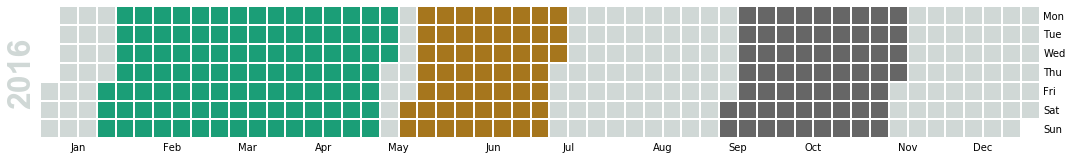

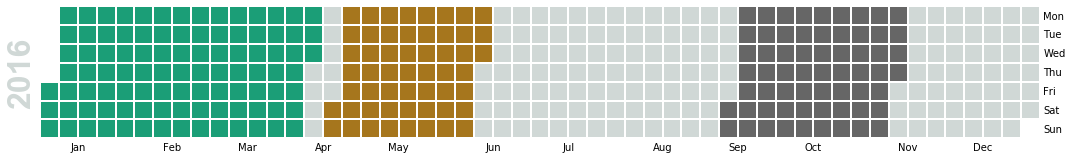

In [23]:
Time4gapKF = [] # custon CVIterator
m = 4  #4 weeks = size of shifting 

def get_valid_folf(df, start, finish):
    test = df.loc[(df.date >= start)&(df.date <= finish)]
    return  test.index

for k in range(4):
    #getting validation fold
    start_v = test.date.min() - relativedelta(days=(9 + m * k) * 7)
    finish_v = test.date.max() - relativedelta(days=(10 + m * k) * 7 + 1)
    validation_indecis = get_valid_folf(train, start_v, finish_v)
    
    #getting training fold
    start_tr = test.date.min() - relativedelta(days=(25 + m * k) * 7 + 1)
    finish_tr = test.date.max() - relativedelta(days=(19 + m * k) * 7 + 1 )
    tmp_train_indices = get_valid_folf(train, start_tr, finish_tr)
    
    #adding train_validation to custom CVIterator 
    Time4gapKF.append((tmp_train_indices, validation_indecis ))

    #vizualizing data which we use in validation
    total_data = pd.concat([train.iloc[tmp_train_indices].date.value_counts() * 0 , 
                            train.iloc[validation_indecis].date.value_counts() * 0.8 , 
                            test.date.value_counts()])
    
    fig, ax = calmap.calendarplot(total_data, fig_kws={"figsize":(15,4)}, fillcolor='#d0d8d6', cmap='Dark2')

In [31]:
def median_smape_validation(CVIterator, train, n_days=15):
    scores = []
    for train_indices, validation_indices in CVIterator:
        tmp_train = train.iloc[train_indices].copy()
        tmp_test = train.iloc[validation_indices].copy()
        score = get_median_smape(tmp_train, tmp_test, n_days=n_days)
        scores.append(score)
    return scores, np.mean(scores)



CVs = [KFold, Time4KF,  Time3KF, Time4gapKF]
name = ['kfold', 'time4kf', 'time3kf', 'time4gapkf']

for cv, name  in zip(CVs, name):
    print(name)
    print("CV score :  {} \nTest score:  {}"
          .format(median_smape_validation(cv, train)[1],
                  get_median_smape(train, test, n_days=15))) 

kfold
CV score :  41.19977854470543 
Test score:  40.00701270204617
time4kf
CV score :  39.678541972493804 
Test score:  40.00701270204617
time3kf
CV score :  37.87304218755918 
Test score:  40.00701270204617
time4gapkf
CV score :  43.54303725526308 
Test score:  40.00701270204617


### ==============================================================================================================

##   Feature engineering

In [32]:
train = pd.read_csv("../data/wikipedia3/wikipedia_train3.csv", parse_dates=['date'])
test = pd.read_csv("../data/wikipedia3/wikipedia_test3.csv", parse_dates=['date'])

In [33]:
import re 

def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        return res.group(0)[0:2]
    return 'na'

def get_access(url):
    return url.split('_')[-2]

def get_features(data):
    df = data.copy()
    df['dayofweek'] = data.date.apply(lambda x: x.dayofweek )
    df['dayofmonth'] = data.date.apply(lambda x: x.day )
    df['weekend'] = data.date.apply(lambda x: x.dayofweek // 5 )
    df['lang'] = data.Page.apply(lambda x: get_language(x))
    df['access'] = data.Page.apply(lambda x: get_access(x))
    df['week'] = df.date.apply(lambda x: x.week)
    return df

def encode(df):
    enc = LabelEncoder()
    df.Page = enc.fit_transform(df.Page)
    df.lang = enc.fit_transform(df.lang)
    df.access = enc.fit_transform(df.access)
    return df 

In [34]:
def prepare(train, test):
    train_df = encode(get_features(train))
    test_df = encode(get_features(test))
    
    X_train = train_df.drop(['date', 'Visits'], axis=1)
    X_test = test_df.drop(['date', 'Visits'], axis=1)
    
    y_train = train_df.Visits
    y_test = test_df.Visits
    return X_train, X_test, y_train, y_test

def smape_for_cross_val(estimator, X_test, y_true):
    return smape_fast(y_true, estimator.predict(X_test).round())

In [35]:
xtrain, xtest, ytrain, ytest = prepare(train, test)

In [37]:
name = ['kfold', 'time4kf', 'time3kf', 'time4gapkf']

estimator=DecisionTreeRegressor(random_state=42)
smape_test = smape_fast(ytest, DecisionTreeRegressor(random_state=42).fit(xtrain, ytrain).predict(xtest).round())
print(f"Test SMAPE: {smape_test}")
for cv, name  in zip(CVs, name):
    print(name, ":  ", end = '')
    score = cross_val_score(estimator=estimator, cv=cv, X=xtrain,
                         scoring=smape_for_cross_val, y=ytrain).mean()
    print(score)

Test SMAPE: 45.1850001088571
t :  46.591837288
i :  42.3854456093
m :  37.7219863488
e :  47.0568798933


## Grid Search

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
estimator = DecisionTreeRegressor(random_state=42)

# create parameter grid
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
params = {
          'max_depth': [ None, 15, 100, 150, 200],
         
          'max_features': [3, 4, 5, 6]
         
    
}

scorer = make_scorer(smape_fast, greater_is_better=False)

# create grid search object
gs = GridSearchCV(
    estimator=estimator,  # base model
    param_grid=params,  # params grid to search within
    cv=Time4gapKF,  # cross-validation strategy
    error_score=1,  # warnings only
    scoring=scorer,  # f1-score
    # thread count, the higher count - the faster
    n_jobs=4,
    verbose=2,  # messages about performed actions
)

# perform grid search on TRAIN dataset ('is_train' filtering)
gs.fit( X=xtrain, y=ytrain)
# -

Fitting 4 folds for each of 20 candidates, totalling 80 fits
[CV] max_depth=None, max_features=3 ..................................
[CV] max_depth=None, max_features=3 ..................................
[CV] max_depth=None, max_features=3 ..................................
[CV] max_depth=None, max_features=3 ..................................
[CV] ................... max_depth=None, max_features=3, total=  18.8s
[CV] max_depth=None, max_features=4 ..................................
[CV] ................... max_depth=None, max_features=3, total=  18.4s
[CV] max_depth=None, max_features=4 ..................................
[CV] ................... max_depth=None, max_features=3, total=  18.9s
[CV] max_depth=None, max_features=4 ..................................
[CV] ................... max_depth=None, max_features=3, total=  19.0s
[CV] max_depth=None, max_features=4 ..................................
[CV] ................... max_depth=None, max_features=4, total=  19.3s
[CV] ...........

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  6.9min


[CV] .................... max_depth=100, max_features=3, total=  19.8s
[CV] max_depth=100, max_features=4 ...................................
[CV] .................... max_depth=100, max_features=3, total=  19.6s
[CV] max_depth=100, max_features=4 ...................................
[CV] .................... max_depth=100, max_features=3, total=  19.6s
[CV] max_depth=100, max_features=4 ...................................
[CV] .................... max_depth=100, max_features=4, total=  21.7s
[CV] max_depth=100, max_features=5 ...................................
[CV] .................... max_depth=100, max_features=4, total=  22.5s
[CV] max_depth=100, max_features=5 ...................................
[CV] .................... max_depth=100, max_features=4, total=  22.4s
[CV] max_depth=100, max_features=5 ...................................
[CV] .................... max_depth=100, max_features=4, total=  22.1s
[CV] max_depth=100, max_features=5 ...................................
[CV] .

[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed: 15.5min finished


GridSearchCV(cv=[(Int64Index([ 909755,  909756,  909757,  909758,  909759,  909760,  909761,
             909762,  909763,  909764,
            ...
            2138505, 2138506, 2138507, 2138508, 2138509, 2138510, 2138511,
            2138512, 2138513, 2138514],
           dtype='int64', length=1228760), Int64In...1890395, 1890396,
            1890397, 1890398, 1890399],
           dtype='int64', length=638010))],
       error_score=1,
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best'),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'max_depth': [None, 15, 100, 150, 200], 'max_features': [3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer

In [40]:
best_dt = gs.best_estimator_

best_dt.fit(xtrain, ytrain)
test_smape = smape_fast(ytest, best_dt.predict(xtest))
cv_smape = cross_val_score(estimator=best_dt, cv=Time4gapKF, X=xtrain,
                         scoring=smape_for_cross_val, y=ytrain).mean()

print(f"CV SMAPE: {cv_smape}\nTest SMAPE: {test_smape}\nDiff: {round(abs(cv_smape - test_smape),4)}")

CV SMAPE: 46.83611267349694
Test SMAPE: 45.10953477755911
Diff: 1.7266
